In [1]:
# !pip install numpy pandas scikit-learn lightgbm

In [2]:
# =========================
# Global settings & imports
# =========================

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd

# Models
from lightgbm import LGBMClassifier as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Pipeline & model selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)

# Preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

# Metrics & evaluation
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    fbeta_score
)

# Utilities
from sklearn.base import clone


In [3]:
# =========================
# Load & clean dataset
# =========================

df = pd.read_csv("WineQT.csv")

# Drop unnecessary columns
df.drop(columns=["Id"], inplace=True)

# Clean column names
df.columns = df.columns.str.replace(" ", "_")


In [4]:
# =========================
# Target transformation
# =========================

def bin_quality(q: int) -> int:
    """
    Convert wine quality score into 3-class target:
    0: low (<=5)
    1: medium (6)
    2: high (>=7)
    """
    if q <= 5:
        return 0
    elif q == 6:
        return 1
    else:
        return 2


df["quality"] = df["quality"].apply(bin_quality)


In [5]:
# =========================
# Feature engineering
# =========================

df["pow_volatile_acidity"] = np.power(df.volatile_acidity, 0.4)
df["pow_chlorides"] = np.power(df.chlorides, -0.5)
df["log_chlorides"] = np.log(df.chlorides)
df["sqrt_total_sulfur_dioxide"] = np.sqrt(df.total_sulfur_dioxide)

df["100x_density"] = df.density * 100
df["100x_sulphates"] = df.sulphates * 100
df["negative_pow_alcohol"] = np.power(df.alcohol, 0.6)


In [6]:
# =========================
# Train / test split
# =========================

X = df.drop(columns=["quality"])
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [7]:
# =========================
# Base pipeline
# =========================

pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression())
    ]
)


In [8]:
# =========================
# Hyperparameter search space
# =========================

param_grid = [

    # Logistic Regression
    {
        "scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],
        "model": [LogisticRegression()],
        "model__max_iter": [100, 200, 500],
        "model__C": [0.1, 1, 10],
    },

    # Support Vector Classifier
    {
        "scaler": [StandardScaler(), MinMaxScaler()],
        "model": [SVC()],
        "model__C": [0.1, 1, 10],
        "model__kernel": ["linear", "rbf"],
    },

    # Random Forest
    {
        "scaler": [None],
        "model": [RandomForestClassifier(random_state=42)],
        "model__n_estimators": [100, 300],
        "model__max_depth": [None, 10, 20],
    },

    # LightGBM
    {
        "scaler": [None],
        "model": [lgb(n_jobs=-1, verbose=-1)],
        "model__objective": ["multiclass"],
        "model__n_estimators": [300, 600],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [None, 10],
    },

    # KNN
    {
        "scaler": [StandardScaler(), MinMaxScaler()],
        "model": [KNeighborsClassifier()],
        "model__n_neighbors": [3, 5, 7, 11, 15],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],
    },
]


In [9]:
# =========================
# Model selection
# =========================

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
)

gs.fit(X_train, y_train)

best_model = gs.best_estimator_


In [10]:
# =========================
# Cost-sensitive decision rule
# =========================

cost_matrix = np.array([
    [0,   1, 8],
    [0.5, 0, 4],
    [2,   1, 0],
])


def predict_with_cost(probs: np.ndarray, alpha: float = 0.17) -> np.ndarray:
    """
    Predict class labels by minimizing expected cost.

    probs : shape (n_samples, n_classes)
    alpha : cost smoothing exponent
    """
    adjusted_cost = np.power(cost_matrix, alpha)

    preds = []
    for p in probs:
        expected_cost = adjusted_cost.T @ p
        preds.append(np.argmin(expected_cost))

    return np.array(preds)


In [11]:
# =========================
# Cross-validation evaluation
# =========================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model_cv = clone(best_model)
    model_cv.fit(X_tr, y_tr)

    probs_val = model_cv.predict_proba(X_val)
    y_pred_val = predict_with_cost(probs_val)

    score = fbeta_score(y_val, y_pred_val, beta=0.7, average="macro")
    cv_scores.append(score)

cv_scores = np.array(cv_scores)
print("CV mean Fβ-score:", cv_scores.mean())


CV mean Fβ-score: 0.6383343969082953


Test Fβ-score: 0.7075411270698124
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       105
           1       0.64      0.72      0.68        92
           2       0.84      0.50      0.63        32

    accuracy                           0.72       229
   macro avg       0.75      0.67      0.69       229
weighted avg       0.73      0.72      0.71       229



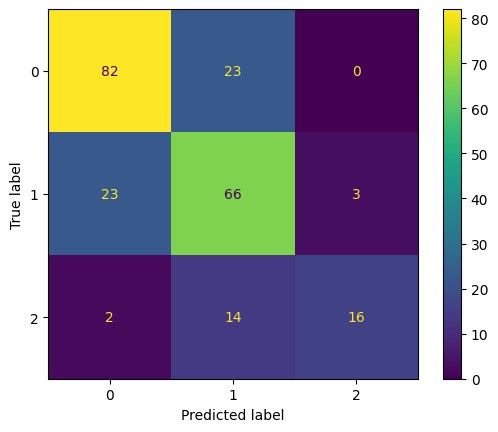

In [12]:
# =========================
# Final test evaluation
# =========================

probs_test = best_model.predict_proba(X_test)
y_pred_test = predict_with_cost(probs_test)

print("Test Fβ-score:",
      fbeta_score(y_test, y_pred_test, beta=0.7, average="macro"))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
print(classification_report(y_test, y_pred_test))


<div align="">
    
**MohammadRezaMahdyan**

<a href="https://github.com/MohammadRezaMahdyan">
  <img src="https://img.shields.io/badge/GitHub-MohammadRezaMahdyan-black?logo=github&logoColor=white" />
</a>
<br/>
<sub>
    • Machine Learning 
    • Cost-Sensitive Modeling 
    • Threshold Optimization
</sub>
</div>
